In [1]:
# basic modules
import os 
import json
import re
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
# SegNet Model with Bayes / None-Bayes
import segnet
# DataLoader modules
from MaSTr1325 import MaSTr1325
# Pytorch modules
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
# selfdefined utils modules
from utils import *

# Device define
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
torch.cuda.empty_cache()

cuda


# Evaluation
![avater](./figures/evaluation_precisions_over_epochs.png)

# Display Sepcific Results using `plot_show`   
`plot_show(epoch=601, img_number=54, ifplot=True)`   
+ `epoch`: `.pth` file selection
+ `img_number`: range from 1 to 132
+ `ifplot`: whether display the result

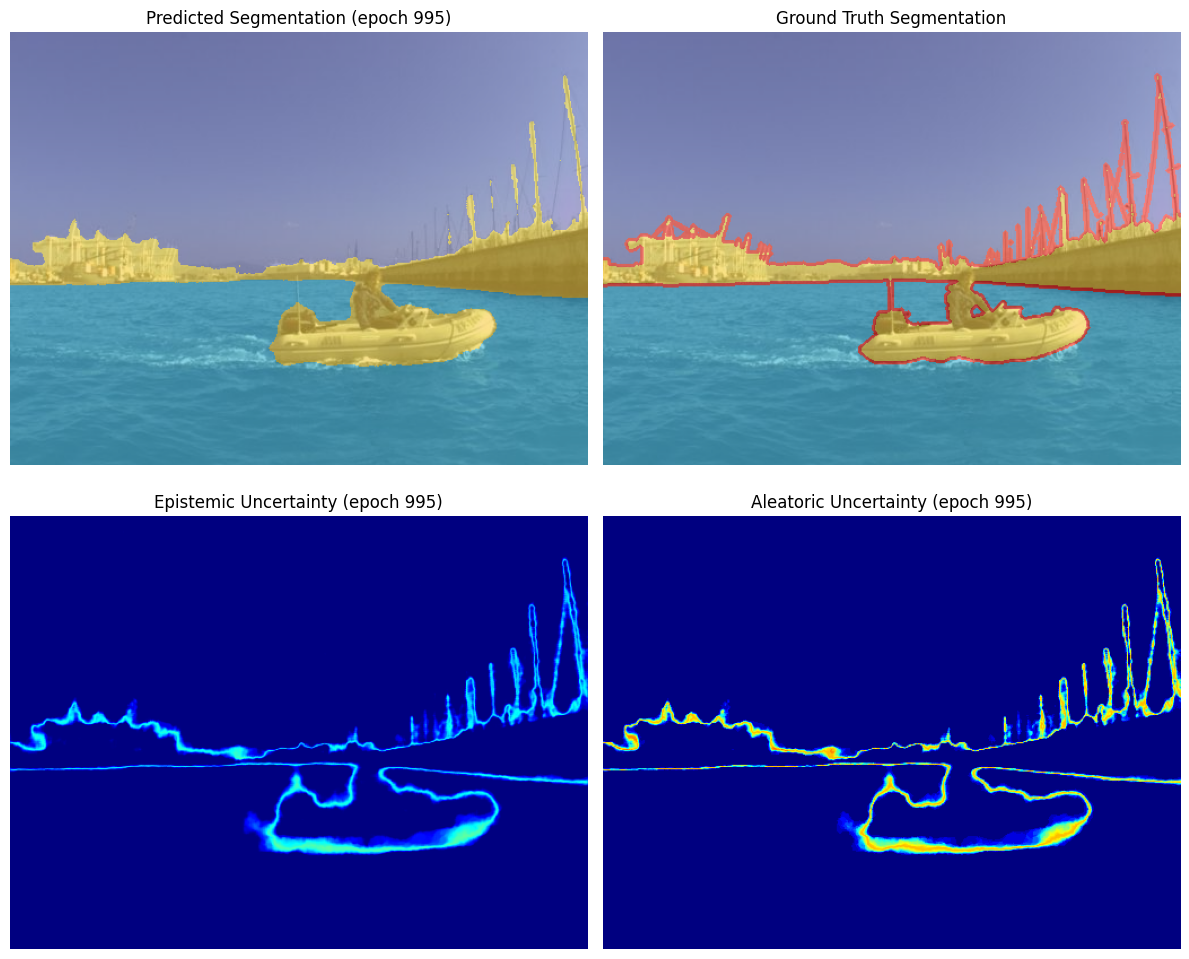

(743,
 1886,
 21317,
 0.2826169646253328,
 0.033680870353581145,
 0.06018874802543644)

In [8]:
import os
from PIL import Image
import numpy as np
import json
import matplotlib.pyplot as plt
import cv2
from tqdm import trange
import matplotlib.patches as patches

# Path
def plot_show(epoch, img_number, ifplot):
    root = os.path.expanduser("~/BDL/BDL-based-semantic-segmentation")
    jpg_path = os.path.join(root, f'Dataset/MaSTr1325/test/{img_number:03d}.jpg')
    json_root = os.path.expanduser(f"~/BDL/SegNet/BayesSegNet-PyTorch/Epistemic-Uncertainty/epoch{epoch}")
    # json_root = f"/mnt/d/video/epoch{epoch}"
    json_path = os.path.join(json_root, f'{img_number:03d}m.json')
    GT_path = os.path.join(root, f'Dataset/MaSTr1325/test_mask/{img_number:03d}m.png') # Groud Truth

    # Define Colour
    threshold = 0.0
    colors = {
        0: (247, 195, 37, 128),    # yellow (RGBA) = obstacle & environment
        1: (41, 167, 224, 128),    # cyan-blue (RGBA) = water
        2: (90, 75, 164, 128),     # purple (RGBA) = sky
        3: (255, 0, 0, 128)        # red (RGBA) = unknown
    }

    # Original JPG Image
    image = Image.open(jpg_path).convert('RGBA')
    # Prediction Segmentation
    with open(json_path, 'r') as json_file:
        mask_data = json.load(json_file)
    mask_array = np.array(mask_data["mean"])[0]
    mask = np.argmax(mask_array, axis=0)
    mask_values = np.max(mask_array, axis=0)
    mask[mask_values < threshold] = 3

    # AU
    au = np.array(mask_data["au"])
    AU = np.zeros((384, 512))
    for o in range(4):
        P = au[o]
        for p in range(384):
            for q in range(512):
                p_hat = P[p,q]
                if p_hat != 0:
                    AU[p,q] += -(p_hat * np.log(p_hat))
    AU = (AU * 255).astype(np.uint8) # quantize and histogram equalization
    AU = cv2.applyColorMap(AU, cv2.COLORMAP_JET)
    AU = AU[:,:,::-1] # BGR to RGB


    mask_image = Image.new('RGBA', image.size)
    mask_pixels = mask_image.load()

    for y in range(mask.shape[0]):
        for x in range(mask.shape[1]):
            value = mask[y, x]
            if value in colors:
                mask_pixels[x, y] = colors[value]

    # Ground Truth
    GT = Image.open(GT_path)
    GT = np.array(GT)
    GT[GT == 4] = 3

    # EU
    EU = np.array(mask_data["std"][0])
    EU = np.transpose(EU, (1, 2, 0))
    # EU = np.sum(EU, axis=2)
    EU = EU[np.arange(EU.shape[0])[:, None], np.arange(EU.shape[1]), mask]
    mask[EU < 0.3] = 3
    EU = (EU * 255).astype(np.uint8) # quantize and histogram equalization
    EU = cv2.applyColorMap(EU, cv2.COLORMAP_JET)
    EU = EU[:,:,::-1] # BGR to RGB

    mask_gt = Image.new('RGBA', image.size)
    gt_pixels = mask_gt.load()

    for y in range(GT.shape[0]):
        for x in range(GT.shape[1]):
            value = GT[y, x]
            if value in colors:
                gt_pixels[x, y] = colors[value]

    # apply mask to jpg
    combined_pred = Image.alpha_composite(image, mask_image)
    combined_gt = Image.alpha_composite(image, mask_gt)

    


    # True Positives (TPs)
    TP =  (GT == 0) & (mask == 0)
    TPs = TP.sum().item()
    # False Positives (FPs)
    FP = (GT != 0) & (mask == 0)
    FPs = FP.sum().item()
    # False Negatives (FNs)
    FN = (GT == 0) & (mask != 0)
    FNs = FN.sum().item()

    Pr = TPs/(TPs + FPs) # Precision (Pr)
    Re = TPs/(TPs + FNs) # Recall (Re)
    if (Pr+Re)==0:
        F1 = 0
    else:
        F1 = 2*Pr*Re/(Pr + Re) # Harmonic Mean F1
    # print(TPs, FPs, FNs, Pr, Re, F1)

    # Plotting
    plt.figure(figsize=(12, 10))

    # Predicted segmentation
    plt.subplot(2, 2, 1)
    plt.imshow(combined_pred)
    plt.title(f'Predicted Segmentation (epoch {epoch})')
    plt.axis('off')

    # Ground truth segmentation
    plt.subplot(2, 2, 2)
    plt.imshow(combined_gt)
    plt.title(f'Ground Truth Segmentation')
    plt.axis('off')

    # Epistemic uncertainty heatmap
    plt.subplot(2, 2, 3)
    plt.imshow(EU)
    plt.title(f'Epistemic Uncertainty (epoch {epoch})')
    plt.axis('off')

    # Aleatoric uncertainty heatmap
    plt.subplot(2, 2, 4)
    plt.imshow(AU)
    plt.title(f'Aleatoric Uncertainty (epoch {epoch})')
    plt.axis('off')

    plt.tight_layout()

    # plt.figure(figsize=(15, 2.5)) 

    # # 绘制子图
    # # Predicted segmentation
    # plt.subplot(1, 5, 1)
    # plt.imshow(image)
    # plt.title(f'Test Image {img_number}')
    # plt.axis('off')

    # # Ground truth segmentation
    # plt.subplot(1, 5, 2)
    # plt.imshow(combined_gt)
    # plt.title(f'Ground Truth')
    # plt.axis('off')

    # # Predicted segmentation
    # plt.subplot(1, 5, 3)
    # plt.imshow(combined_pred)
    # plt.title(f'Semantic Segmentation')
    # plt.axis('off')

    # # Aleatoric uncertainty heatmap
    # plt.subplot(1, 5, 4)
    # plt.imshow(AU)
    # plt.title(f'Aleatoric Uncertainty')
    # plt.axis('off')

    # # Epistemic uncertainty heatmap
    # plt.subplot(1, 5, 5)
    # plt.imshow(EU)
    # plt.title(f'Epistemic Uncertainty')
    # plt.axis('off')

    # plt.tight_layout()
    # # plt.savefig(f'./Video/output{epoch:03}.png')

    if ifplot:
        plt.show()
    else:
        plt.close()
    
    return TPs, FPs, FNs, Pr, Re, F1


# TPr, FPr, FNr, Prs, Res, F1s = 0,0,0,0,0,0
# for i in trange(1,133):
#     TPs, FPs, FNs, Pr, Re, F1 = plot_show(epoch=995, img_number=i, ifplot=False)
#     TPr += TPs
#     FPr += FPs
#     FNr += FNs
#     Prs += Pr
#     Res += Re
#     F1s += F1

# TPr = TPr/i
# FPr = FPr/i
# FNr = FNr/i
# Pr = Prs/i
# Re = Res/i
# F1 = F1s/i

# print(i, TPr, FPr, FNr, Pr, Re, F1)

plot_show(epoch=995, img_number=54, ifplot=True)

0.46217261582358554
0.9202482811811661
0.774054407797624
20519 3984 83 0.8374076643676285 0.9959712649257354 0.9098326127923735


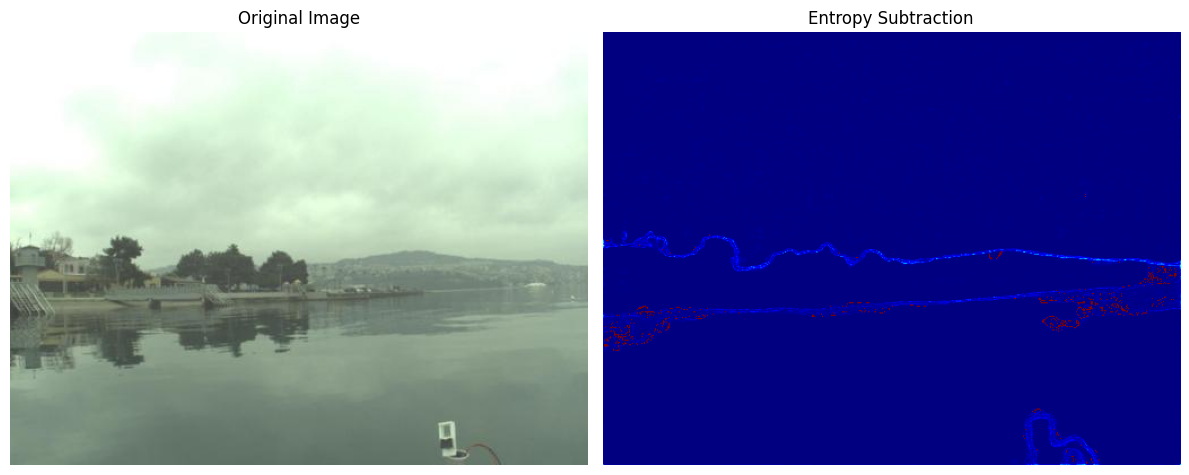

In [86]:
import os
from PIL import Image
import numpy as np
import json
import matplotlib.pyplot as plt
import cv2
from tqdm import trange
import matplotlib.patches as patches

# Path
def plot_show(epoch, img_number, ifplot):
    root = os.path.expanduser("~/BDL/BDL-based-semantic-segmentation")
    jpg_path = os.path.join(root, f'Dataset/MaSTr1325/test/{img_number:03d}.jpg')
    json_root = os.path.expanduser(f"~/BDL/SegNet/BayesSegNet-PyTorch/Epistemic-Uncertainty/epoch{epoch}")
    # json_root = f"/mnt/d/video/epoch{epoch}"
    json_path = os.path.join(json_root, f'{img_number:03d}m.json')
    GT_path = os.path.join(root, f'Dataset/MaSTr1325/test_mask/{img_number:03d}m.png') # Groud Truth

    # Define Colour
    threshold = 0.0
    colors = {
        0: (247, 195, 37, 128),    # yellow (RGBA) = obstacle & environment
        1: (41, 167, 224, 128),    # cyan-blue (RGBA) = water
        2: (90, 75, 164, 128),     # purple (RGBA) = sky
        3: (255, 0, 0, 128)        # red (RGBA) = unknown
    }

    # Original JPG Image
    image = Image.open(jpg_path).convert('RGBA')
    # Prediction Segmentation
    with open(json_path, 'r') as json_file:
        mask_data = json.load(json_file)
    mask_array = np.array(mask_data["mean"])[0]
    mask = np.argmax(mask_array, axis=0)
    mask_values = np.max(mask_array, axis=0)
    mask[mask_values < threshold] = 3

    # AU
    au = np.array(mask_data["au"])
    AU = np.zeros((384, 512))
    for o in range(4):
        P = au[o]
        for p in range(384):
            for q in range(512):
                p_hat = P[p,q]
                if p_hat != 0:
                    AU[p,q] += -(p_hat * np.log(p_hat))


    # softmax entropy
    softmax = np.array(mask_data["mean"])[0]
    SE = np.zeros((384, 512))
    for o in range(4):
        P = softmax[o]
        for p in range(384):
            for q in range(512):
                p_hat = P[p,q]
                if p_hat != 0:
                    SE[p,q] += -(p_hat * np.log(p_hat))
    EU = SE - AU
    print(EU.max())
    print(SE.max())
    print(AU.max())
    # EU = (EU - np.min(EU)) / (np.max(EU) - np.min(EU))
    

    AU = (AU * 255).astype(np.uint8) # quantize and histogram equalization
    AU = cv2.applyColorMap(AU, cv2.COLORMAP_JET)
    AU = AU[:,:,::-1] # BGR to RGB
    SE = (SE * 255).astype(np.uint8) # quantize and histogram equalization
    SE = cv2.applyColorMap(SE, cv2.COLORMAP_JET)
    SE = SE[:,:,::-1] # BGR to RGB

    # # EU
    # EU = np.array(mask_data["std"][0])
    # EU = np.transpose(EU, (1, 2, 0))
    # # EU = np.sum(EU, axis=2)/2
    # EU = EU[np.arange(EU.shape[0])[:, None], np.arange(EU.shape[1]), mask]
    # # mask[EU > 0.3] = 3
    EU = (EU * 255).astype(np.uint8) # quantize and histogram equalization
    EU = cv2.applyColorMap(EU, cv2.COLORMAP_JET)
    EU = EU[:,:,::-1] # BGR to RGB


    mask_image = Image.new('RGBA', image.size)
    mask_pixels = mask_image.load()

    for y in range(mask.shape[0]):
        for x in range(mask.shape[1]):
            value = mask[y, x]
            if value in colors:
                mask_pixels[x, y] = colors[value]

    # Ground Truth
    GT = Image.open(GT_path)
    GT = np.array(GT)
    GT[GT == 4] = 3

    mask_gt = Image.new('RGBA', image.size)
    gt_pixels = mask_gt.load()

    for y in range(GT.shape[0]):
        for x in range(GT.shape[1]):
            value = GT[y, x]
            if value in colors:
                gt_pixels[x, y] = colors[value]

    # apply mask to jpg
    combined_pred = Image.alpha_composite(image, mask_image)
    combined_gt = Image.alpha_composite(image, mask_gt)

    # True Positives (TPs)
    TP =  (GT == 0) & (mask == 0)
    TPs = TP.sum().item()
    # False Positives (FPs)
    FP = (GT != 0) & (mask == 0)
    FPs = FP.sum().item()
    # False Negatives (FNs)
    FN = (GT == 0) & (mask != 0)
    FNs = FN.sum().item()

    Pr = TPs/(TPs + FPs) # Precision (Pr)
    Re = TPs/(TPs + FNs) # Recall (Re)
    if (Pr+Re)==0:
        F1 = 0
    else:
        F1 = 2*Pr*Re/(Pr + Re) # Harmonic Mean F1
    print(TPs, FPs, FNs, Pr, Re, F1)

    # Plotting
    plt.figure(figsize=(11, 10))

    # Predicted segmentation
    plt.subplot(2, 2, 1)
    plt.imshow(combined_pred)
    plt.title(f'Predicted Segmentation (epoch {epoch})')
    plt.axis('off')

    # Ground truth segmentation
    plt.subplot(2, 2, 2)
    plt.imshow(combined_gt)
    plt.title(f'Ground Truth Segmentation')
    plt.axis('off')

    # Epistemic uncertainty heatmap
    plt.subplot(2, 2, 3)
    plt.imshow(EU)
    plt.title(f'Epistemic Uncertainty (epoch {epoch})')
    plt.axis('off')

    # Aleatoric uncertainty heatmap
    plt.subplot(2, 2, 4)
    plt.imshow(AU)
    plt.title(f'Aleatoric Uncertainty (epoch {epoch})')
    plt.axis('off')

    plt.tight_layout()
    if ifplot:
        plt.show()
    else:
        plt.close()
    
#     return TPs, FPs, FNs, Pr, Re, F1

# TPr, FPr, FNr, Prs, Res, F1s = 0,0,0,0,0,0
# for i in trange(1,133):
#     TPs, FPs, FNs, Pr, Re, F1 = plot_show(epoch=995, img_number=i, ifplot=False)
#     TPr += TPs
#     FPr += FPs
#     FNr += FNs
#     Prs += Pr
#     Res += Re
#     F1s += F1

# TPr = TPr/i
# FPr = FPr/i
# FNr = FNr/i
# Pr = Prs/i
# Re = Res/i
# F1 = F1s/i

# print(i, TPr, FPr, FNr, Pr, Re, F1)

    plt.figure(figsize=(12, 5))

    # Predicted segmentation
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title(f'Original Image')
    plt.axis('off')

    # Ground truth segmentation
    plt.subplot(1, 2, 2)
    plt.imshow(EU)
    plt.title(f'Entropy Subtraction')
    plt.axis('off')

    plt.tight_layout()

plot_show(epoch=995, img_number=20, ifplot=False)

# Epistemic Uncertainty
### Generate `.json` files for Epistemic Uncertainty Display

In [ ]:
def eval(epoch, k):
    # Define root path
    root = os.path.expanduser("~/BDL/BDL-based-semantic-segmentation/Dataset/MaSTr1325")
    # print(f"root path: {root}")
    json_root = os.path.expanduser(f"~/BDL/SegNet/BayesSegNet-PyTorch/Epistemic-Uncertainty/epoch{epoch}")
    if not os.path.exists(json_root):
        os.makedirs(json_root)
    # print(f"json root path: {json_root}")

    # Define transform
    transform = transforms.Compose([
    transforms.Resize((384, 512)),
    transforms.ToTensor(),
    # LocalContrastNormalisation(3, 0, 1)
    ])
    target_transform = transforms.Compose([
    transforms.Resize((384, 512)),
    PILToLongTensor()
    ])
    # DataLoader for val/test
    test_data = MaSTr1325(root, "test", transform=transform, target_transform=target_transform)
    test_loader = DataLoader(test_data, batch_size=1)

    num_classes = len(test_data.color_encoding)
    # print(f"The Number of Classes: {num_classes}")

    # Model Import
    model = segnet.BayesSegNet(in_channels=3, out_channels=num_classes, vgg_encoder=True)
    model.to(device)

    model_path = os.path.expanduser(f"./saved_model/SegNet_MaSTr1325_8_{epoch}.pth")
    model.load_state_dict(torch.load(model_path))

    # Validation
    model.train()
    i=0
    for X, y in tqdm(test_loader, desc=f"Testing Epoch {x}"):
        X, y = X.to(device), y.to(device).squeeze(1) # targets only have one channel
        # monte carlo sample
        y_logit = []
        AU = np.zeros((4, 384, 512))
        for _ in range(k):
            y_numpy = model(X).detach().cpu().numpy()
            y_logit.append(y_numpy)
            mask = np.argmax(y_numpy[0], axis=0)
            for o in range(384):
                for p in range(512):
                    pixel_value = mask[o, p]
                    if pixel_value in [0, 1, 2, 4]: 
                        index = [0, 1, 2, 3][[0, 1, 2, 4].index(pixel_value)]
                        AU[index, o, p] += 1


        y_logit = np.stack(y_logit, axis=0)
        y_logit_mean = np.mean(y_logit, axis=0)  # mean
        y_logit_std = np.std(y_logit, axis=0)  # std
        AU = AU/k # Aleatoric Uncertainty
        y_logit = {"mean": y_logit_mean.tolist(), "std": y_logit_std.tolist(), "au": AU.tolist()}

        # Save results
        json_path = os.path.join(json_root,f"{i+1:03d}m.json")
        with open(json_path, 'w') as json_file:
            json.dump(y_logit, json_file)
        i = i+1

        del X, y, y_logit, y_logit_mean, y_logit_std


# test
# folder_path = './saved_model'
# all_files = os.listdir(folder_path)
# pattern = re.compile(r'SegNet_MaSTr1325_8_(\d+)\.pth')
# k = 100 # monte carlo sample times
# for file in all_files:
#     match = pattern.match(file)
#     if match:
#         x = int(match.group(1))
#         eval(x, k)

eval(995, 100)

### Generate Video for Epistemic Uncertainty changing with epochs

In [ ]:
import cv2
import os
import re

# Generate Frames
for img_number in range(1,133):
    folders = os.listdir('/mnt/d/Bayesian-SegNet/json_mask')
    # img_number = 54
    for folder in folders:
        match = re.match(r'epoch(\d+)', folder)
        if match:
            epoch = int(match.group(1))
            plot_show(epoch=epoch, img_number=img_number, ifplot=False)


    # Generate Video
    png_folder = './Video'
    avi_filename = f'./Video/test{img_number:03d}.avi'

    png_files = sorted([f for f in os.listdir(png_folder) if f.endswith('.png')])
    first_image = cv2.imread(os.path.join(png_folder, png_files[0]))
    height, width, layers = first_image.shape
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    video = cv2.VideoWriter(avi_filename, fourcc, 0.75, (width, height))
    for file in png_files:
        image = cv2.imread(os.path.join(png_folder, file))
        video.write(image)
    video.release()
    print(f"video generated ==> {avi_filename}")

    # Delete Frames
    for file in png_files:
        image_path = os.path.join(png_folder, file)
        if image_path != avi_filename:
            os.remove(image_path)

In [90]:
# basic modules
import os 
import json
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
# SegNet Model with Bayes / None-Bayes
import segnet
# DataLoader modules
from MaSTr1325 import MaSTr1325
from OASIs import OASIs
# Pytorch modules
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
# selfdefined utils modules
from utils import *

# Device define
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
torch.cuda.empty_cache()

def eval(epoch, k):
    # Define root path
    root = os.path.expanduser("~/BDL/BDL-based-semantic-segmentation/Dataset/OASIs")
    # print(f"root path: {root}")
    json_root = os.path.expanduser(f"~/BDL/SegNet/BayesSegNet-PyTorch/OASIs")
    if not os.path.exists(json_root):
        os.makedirs(json_root)
    # print(f"json root path: {json_root}")

    # Define transform
    transform = transforms.Compose([
    transforms.Resize((384, 512)),
    transforms.ToTensor(),
    # LocalContrastNormalisation(3, 0, 1)
    ])
    target_transform = transforms.Compose([
    transforms.Resize((384, 512)),
    PILToLongTensor()
    ])
    # DataLoader for val/test
    data = OASIs(root, image_set="type2", transform=transform, target_transform=target_transform)
    data_loader = DataLoader(data, batch_size=1)

    num_classes = len(data.color_encoding)
    # print(f"The Number of Classes: {num_classes}")

    # Model Import
    model = segnet.BayesSegNet(in_channels=3, out_channels=num_classes, vgg_encoder=True)
    model.to(device)

    model_path = os.path.expanduser(f"./saved_model/SegNet_MaSTr1325_8_{epoch}.pth")
    model.load_state_dict(torch.load(model_path))

    # Validation
    model.train()
    i=0
    for X, y in tqdm(data_loader, desc="Testing Process"):
        X, y = X.to(device), y.to(device).squeeze(1) # targets only have one channel
        # monte carlo sample
        y_logit = []
        AU = np.zeros((4, 384, 512))
        for _ in range(k):
            y_numpy = model(X).detach().cpu().numpy()
            y_logit.append(y_numpy)
            mask = np.argmax(y_numpy[0], axis=0)
            for o in range(384):
                for p in range(512):
                    pixel_value = mask[o, p]
                    if pixel_value in [0, 1, 2, 4]: 
                        index = [0, 1, 2, 3][[0, 1, 2, 4].index(pixel_value)]
                        AU[index, o, p] += 1


        y_logit = np.stack(y_logit, axis=0)
        y_logit_mean = np.mean(y_logit, axis=0)  # mean
        y_logit_std = np.std(y_logit, axis=0)  # std
        AU = AU/k # Aleatoric Uncertainty
        y_logit = {"mean": y_logit_mean.tolist(), "std": y_logit_std.tolist(), "au": AU.tolist()}

        # Save results
        json_path = os.path.join(json_root,f"{i+1:03d}m.json")
        with open(json_path, 'w') as json_file:
            json.dump(y_logit, json_file)
        i = i+1

        del X, y, y_logit, y_logit_mean, y_logit_std

eval(995, 100)

cuda


Testing Process: 100%|██████████| 30/30 [08:52<00:00, 17.75s/it]


70 0.6742641163669683 0.7216229468006864 0.6971401503937473


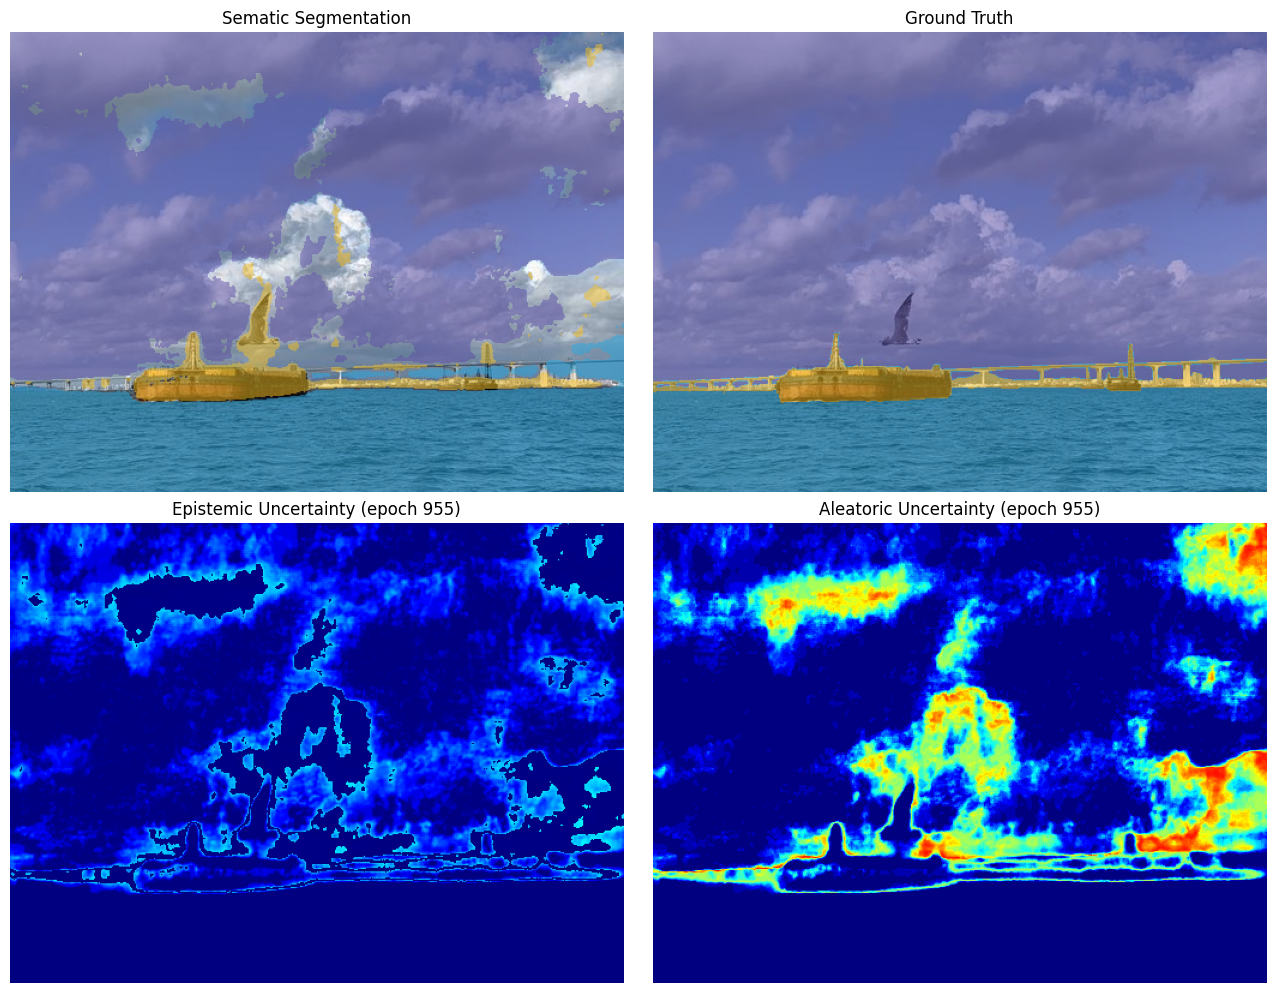

(0.6742641163669683, 0.7216229468006864, 0.6971401503937473)

In [109]:
import os
from PIL import Image
import numpy as np
import json
import matplotlib.pyplot as plt
import cv2

# Path
def plot_show(epoch, img_number, ifplot, type):
    root = os.path.expanduser("~/BDL/BDL-based-semantic-segmentation")
    jpg_path = os.path.join(root, f'Dataset/OASIs/type{type}/{img_number:03d}.jpg')
    json_root = os.path.expanduser(f"~/BDL/SegNet/BayesSegNet-PyTorch/OASIs/type{type}")
    json_path = os.path.join(json_root, f'{img_number:03d}m.json')
    GT_path = os.path.join(root, f'Dataset/OASIs/type{type}_mask/{img_number:03d}m.png') # Groud Truth

    # Define Colour
    threshold = 0.8
    colors = {
        0: (247, 195, 37, 128),    # yellow (RGBA) = obstacle & environment
        1: (41, 167, 224, 128),    # cyan-blue (RGBA) = water
        2: (90, 75, 164, 128),     # purple (RGBA) = sky
        3: (255, 0, 0, 0)        # red (RGBA) = unknown
    }

    # Original JPG Image
    image = Image.open(jpg_path).convert('RGBA')
    # Prediction Segmentation
    with open(json_path, 'r') as json_file:
        mask_data = json.load(json_file)
    mask_array = np.array(mask_data["mean"])[0]
    mask = np.argmax(mask_array, axis=0)
    mask_values = np.max(mask_array, axis=0)
    mask[mask_values < threshold] = 3

    # AU
    au = np.array(mask_data["au"])
    AU = np.zeros((384, 512))
    for o in range(4):
        P = au[o]
        for p in range(384):
            for q in range(512):
                p_hat = P[p,q]
                if p_hat != 0:
                    AU[p,q] += -(p_hat * np.log(p_hat))


    AU = (AU * 200).astype(np.uint8) # quantize and histogram equalization
    AU = cv2.applyColorMap(AU, cv2.COLORMAP_JET)
    AU = AU[:,:,::-1] # BGR to RGB

    # EU
    EU = np.array(mask_data["std"][0])
    EU = np.transpose(EU, (1, 2, 0))
    # EU = np.sum(EU, axis=2)/2
    EU = EU[np.arange(EU.shape[0])[:, None], np.arange(EU.shape[1]), mask]
    EU = (EU * 255).astype(np.uint8) # quantize and histogram equalization
    EU = cv2.applyColorMap(EU, cv2.COLORMAP_JET)
    EU = EU[:,:,::-1] # BGR to RGB

    mask_image = Image.new('RGBA', image.size)
    mask_pixels = mask_image.load()

    for y in range(mask.shape[0]):
        for x in range(mask.shape[1]):
            value = mask[y, x]
            if value in colors:
                mask_pixels[x, y] = colors[value]

    # Ground Truth
    GT = Image.open(GT_path)
    GT = np.array(GT)
    GT[GT == 4] = 3

    mask_gt = Image.new('RGBA', image.size)
    gt_pixels = mask_gt.load()

    for y in range(GT.shape[0]):
        for x in range(GT.shape[1]):
            value = GT[y, x]
            if value in colors:
                gt_pixels[x, y] = colors[value]

    # apply mask to jpg
    combined_pred = Image.alpha_composite(image, mask_image)
    combined_gt = Image.alpha_composite(image, mask_gt)

    # Validation
    TP = ((GT == 0) & (mask == 0)).sum() # True Positives
    FP = ((GT != 0) & (mask == 0)).sum() # False Positives
    FN = ((GT == 0) & (mask != 0)).sum() # False Negatives
    Pr = 0 if (TP + FP) == 0 else TP/(TP + FP) # Precision (Pr)
    Re = 0 if (TP + FN) == 0 else TP/(TP + FN) # Recall (Re)
    F1 = 0 if (Pr + Re) == 0 else 2*Pr*Re/(Pr + Re) # Harmonic Mean F1
    print(img_number, Pr, Re, F1)

    # Plotting
    plt.figure(figsize=(13, 10))

    # Predicted segmentation
    plt.subplot(2, 2, 1)
    plt.imshow(combined_pred)
    plt.title(f'Sematic Segmentation')
    plt.axis('off')

    # Ground truth segmentation
    plt.subplot(2, 2, 2)
    plt.imshow(combined_gt)
    plt.title(f'Ground Truth')
    plt.axis('off')

    # Epistemic uncertainty heatmap
    plt.subplot(2, 2, 3)
    plt.imshow(EU)
    plt.title(f'Epistemic Uncertainty (epoch {epoch})')
    plt.axis('off')

    # Aleatoric uncertainty heatmap
    plt.subplot(2, 2, 4)
    plt.imshow(AU)
    plt.title(f'Aleatoric Uncertainty (epoch {epoch})')
    plt.axis('off')

    plt.tight_layout()
    # plt.savefig(f'./Uncertainty/output{epoch:03}-g{std}.png')

    if ifplot:
        plt.show()
    else:
        plt.close()

    return Pr, Re, F1

# for img_number in range(1,98):
plot_show(epoch=955, img_number=70, ifplot=True, type = 1)

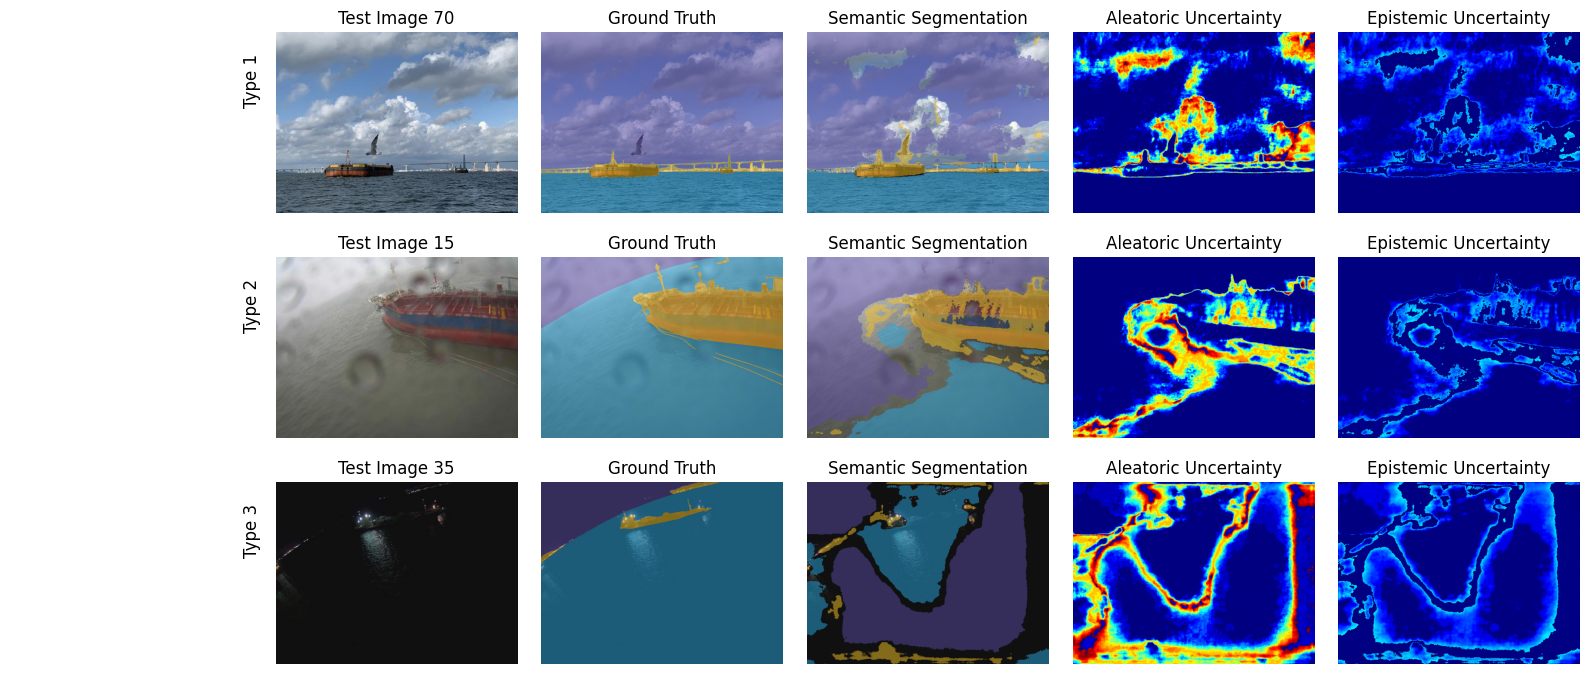

In [104]:
import os
from PIL import Image
import numpy as np
import json
import matplotlib.pyplot as plt
import cv2

# Path
def plot_show(epoch, img_number, ifplot, type):
    root = os.path.expanduser("~/BDL/BDL-based-semantic-segmentation")
    jpg_path = os.path.join(root, f'Dataset/OASIs/type{type}/{img_number:03d}.jpg')
    json_root = os.path.expanduser(f"~/BDL/SegNet/BayesSegNet-PyTorch/OASIs/type{type}")
    json_path = os.path.join(json_root, f'{img_number:03d}m.json')
    GT_path = os.path.join(root, f'Dataset/OASIs/type{type}_mask/{img_number:03d}m.png') # Groud Truth

    # Define Colour
    threshold = 0.8
    colors = {
        0: (247, 195, 37, 128),    # yellow (RGBA) = obstacle & environment
        1: (41, 167, 224, 128),    # cyan-blue (RGBA) = water
        2: (90, 75, 164, 128),     # purple (RGBA) = sky
        3: (255, 0, 0, 0)        # red (RGBA) = unknown
    }

    # Original JPG Image
    image = Image.open(jpg_path).convert('RGBA')
    # Prediction Segmentation
    with open(json_path, 'r') as json_file:
        mask_data = json.load(json_file)
    mask_array = np.array(mask_data["mean"])[0]
    mask = np.argmax(mask_array, axis=0)
    mask_values = np.max(mask_array, axis=0)
    mask[mask_values < threshold] = 3

    # Aleatoric Uncertainty
    EU = np.array(mask_data["std"][0])
    EU = np.transpose(EU, (1, 2, 0))
    # EU = np.sum(EU, axis=2)
    EU = EU[np.arange(EU.shape[0])[:, None], np.arange(EU.shape[1]), mask]
    EU = (EU * 255).astype(np.uint8) # quantize and histogram equalization
    EU = cv2.applyColorMap(EU, cv2.COLORMAP_JET)
    EU = EU[:,:,::-1] # BGR to RGB

    # AU
    au = np.array(mask_data["au"])
    AU = np.zeros((384, 512))
    for o in range(4):
        P = au[o]
        for p in range(384):
            for q in range(512):
                p_hat = P[p,q]
                if p_hat != 0:
                    AU[p,q] += -(p_hat * np.log(p_hat))
    AU = (AU * 255).astype(np.uint8) # quantize and histogram equalization
    AU = cv2.applyColorMap(AU, cv2.COLORMAP_JET)
    AU = AU[:,:,::-1] # BGR to RGB


    mask_image = Image.new('RGBA', image.size)
    mask_pixels = mask_image.load()

    for y in range(mask.shape[0]):
        for x in range(mask.shape[1]):
            value = mask[y, x]
            if value in colors:
                mask_pixels[x, y] = colors[value]

    # Ground Truth
    GT = Image.open(GT_path)
    GT = np.array(GT)
    GT[GT == 4] = 3

    mask_gt = Image.new('RGBA', image.size)
    gt_pixels = mask_gt.load()

    for y in range(GT.shape[0]):
        for x in range(GT.shape[1]):
            value = GT[y, x]
            if value in colors:
                gt_pixels[x, y] = colors[value]

    # apply mask to jpg
    combined_pred = Image.alpha_composite(image, mask_image)
    combined_gt = Image.alpha_composite(image, mask_gt)

    return image, combined_pred, combined_gt, AU, EU

# Plotting
plt.figure(figsize=(16, 7))  # 将图像宽度增加，以适应新的标题区域

i = 0
for img_number in [70, 15, 35]:
    image, combined_pred, combined_gt, AU, EU = plot_show(epoch=995, img_number=img_number, ifplot=True, type=i+1)
    
    # 添加竖着的标题的空白区域
    plt.subplot(3, 6, (6*i+1))  # 调整subplot的列数从5到6，添加一个新区域
    plt.axis('off')  # 隐藏坐标轴
    title = f'Type {i+1}'
    plt.text(1, 0.7, title, fontsize=12, ha='center', va='center', rotation=90)  # 添加竖排标题

    # Test Image
    plt.subplot(3, 6, (6*i+2))  # 调整位置
    plt.imshow(image)
    plt.title(f'Test Image {img_number}')
    plt.axis('off')

    # Ground truth segmentation
    plt.subplot(3, 6, (6*i+3))  # 调整位置
    plt.imshow(combined_gt)
    plt.title(f'Ground Truth')
    plt.axis('off')

    # Predicted segmentation
    plt.subplot(3, 6, (6*i+4))  # 调整位置
    plt.imshow(combined_pred)
    plt.title(f'Semantic Segmentation')
    plt.axis('off')

    # Aleatoric uncertainty heatmap
    plt.subplot(3, 6, (6*i+5))  # 调整位置
    plt.imshow(AU)
    plt.title(f'Aleatoric Uncertainty')
    plt.axis('off')

    # Epistemic uncertainty heatmap
    plt.subplot(3, 6, (6*i+6))  # 调整位置
    plt.imshow(EU)
    plt.title(f'Epistemic Uncertainty')
    plt.axis('off')

    i += 1

plt.tight_layout()

+ type2:    
    Average: 0.5014056106197295 0.5476538164647083 0.4790926652473136
    ```
    1 0.0 0.0 0
    2 0.02232449512295645 0.10610512569376428 0.03688780432438568
    3 0.0358561967833491 0.10770105143506678 0.05380083753282703
    4 0.11972207375734902 0.20588235294117646 0.15140250084488002
    5 0.6573931894137838 0.7927672784706715 0.7187615732167988
    6 0.946236559139785 0.6942539607472216 0.8008927464352139
    7 0.9625522836369761 0.6956301225350969 0.8076076076076076
    8 0.6720267348142324 0.8197295223479762 0.73856590403353
    9 0.6134128780086402 0.7886690647482014 0.6900877132078965
    10 0.319154291467405 0.7082103247426793 0.4400158635732699
    11 0.22648367700512959 0.6359214040442579 0.33400966909646546
    12 0.3675241864555849 0.7776227029541753 0.4991414706980216
    13 0.7593984962406015 0.8676376203406566 0.8099177362490495
    14 0.9539479336712776 0.8417102569934046 0.8943213854208618
    15 0.8043627563201099 0.7328010011024044 0.7669161209853446
    16 0.6280118359870368 0.30550414696003836 0.411048602785207
    17 0.2047157894736842 0.20238095238095238 0.2035416753882865
    18 0.0 0.0 0
    19 0.003899165759883932 0.00741635046567782 0.0051111375252585285
    20 0.0 0.0 0
    21 0.9317630020871491 0.7524422124380847 0.8325562808045823
    22 0.9202395858008189 0.7511117248998757 0.8271184378611838
    23 0.9208858793564018 0.7966625463535228 0.8542819271553712
    24 0.902409411002887 0.6964144421771541 0.7861415694155531
    25 0.9065285047390013 0.39812686381709744 0.553270019425858
    26 0.9479848554545133 0.37894453952672597 0.5414510913500403
    27 0.27373990531885267 0.9276502044668135 0.42273509174311924
    28 0.2191363895758037 0.9516728624535316 0.3562427522226517
    29 0.22105263157894736 0.9389920424403183 0.3578597732688281
    ```